<a href="https://colab.research.google.com/github/bigya01/cerviscan/blob/main/Cervix%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# PREPROCESSING

In [ ]:
'''
  * loaded images from the file path
  * splitted data into 3 parts : train, test, val
  * removed corrupted pictures, resized to (180,180)
  * normalized pictures by dividing each picture by 255 and dumped it to pickle cause my notebook couldn't take it
  * augmented params of pics like height weight shear zoom etc to introduce diversity

'''


import pickle
train_features,train_labels =None,None
with open('/content/drive/MyDrive/cervix/train.pickle','rb') as handle:
    train_features,train_labels = pickle.load(handle)
val_features, val_labels = None, None
with open('/content/drive/MyDrive/cervix/val.pickle','rb') as handle:
    val_features,val_labels = pickle.load(handle)
test_features, test_labels = None, None
with open('/content/drive/MyDrive/cervix/test.pickle', 'rb') as handle:
    test_features, test_labels = pickle.load(handle)

In [ ]:
# val_features, val_labels = None, None
# with open('/content/drive/MyDrive/cervix/val.pickle','rb') as handle:
#     val_features,val_labels = pickle.load(handle)
# test_features, test_labels = None, None
# with open('/content/drive/MyDrive/cervix/test.pickle', 'rb') as handle:
#     test_features, test_labels = pickle.load(handle)

In [ ]:
# with open('/content/drive/MyDrive/cervix/X_train.pickle', 'wb') as f:
#     pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train = None
with open('/content/drive/MyDrive/cervix/X_train.pickle','rb') as handle:
    X_train = pickle.load(handle)
X_train.shape

(6569, 180, 180, 3)

In [ ]:
X_val = None
with open('/content/drive/MyDrive/cervix/X_val.pickle','rb') as handle:
    X_val = pickle.load(handle)
X_val.shape

(821, 180, 180, 3)

In [ ]:
X_test = None
with open('/content/drive/MyDrive/cervix/X_test.pickle','rb') as handle:
    X_test = pickle.load(handle)
X_test.shape

(822, 180, 180, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creates a mapping s.t type1 assigned 0, type2 1,type3 2
le = LabelEncoder().fit(['Type 1','Type 2','Type 3'])
y_train = le.transform(train_labels)
y_val = le.transform(val_labels)
y_test = le.transform(test_labels)

In [ ]:
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

def add_noise(img):
    VARIABILITY = 50  #extent of intensity of noise to be added
    deviation = VARIABILITY*random.random()  #magnitude of random noise added to img
    #noise with normal distr with magnitude of deviation and noise shape is same as image shape
    noise = np.random.normal(0,deviation,img.shape)
    img += noise
    np.clip(img,0.,255.) #anything below 0 is 0 and above 255 is 255
    return img

train_datagen = ImageDataGenerator(   #so train data sees all kind of diverse data
    rotation_range  = 40,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)
eval_datagen = ImageDataGenerator()  # no augmentation params cause we wanna evaluate model's performance on original dataset


In [ ]:
#augmenting features
BATCH_SIZE = 6
train_gen = train_datagen.flow(X_train,y_train,batch_size = BATCH_SIZE)
val_gen = eval_datagen.flow(X_val,y_val,batch_size = BATCH_SIZE)
test_gen = eval_datagen.flow(X_val,y_val,batch_size = BATCH_SIZE)

In [ ]:
for data_batch, labels_batch in train_gen:
  print('data batch shape:{}\n labels batch shape: {}'.format(data_batch.shape,labels_batch.shape))
  break

data batch shape:(6, 180, 180, 3)
 labels batch shape: (6,)


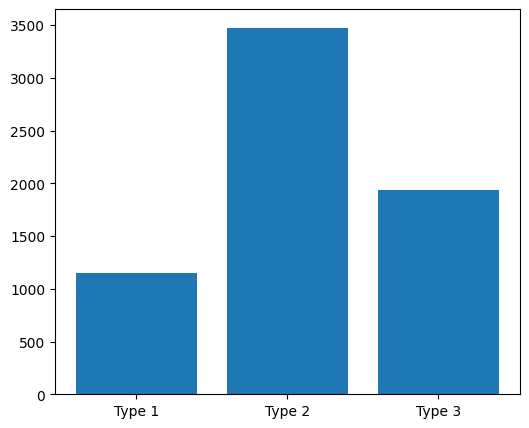

In [ ]:
import matplotlib.pyplot as plt
#visualizing distribution types in training set
labels = list(map(lambda x: int(x[-1]),train_labels))
#extracting X from Type_X string and converting into int
plt.figure(figsize = (6,5))
plt.bar(['Type 1','Type 2', 'Type 3'],[labels.count(1),labels.count(2),labels.count(3)])
plt.show()


# MODEL TRAINING

In [ ]:
#initializing pretrained vgg model base
'''vgg16 is a pre-built nn esp for img classification tasks'''
from keras.applications.vgg16 import VGG16
#its trained on imagenet(HUGE DATASET) it's already learned to recognize wide variety of features in images
#include_top = false because we wanna use it as feature extractor and not sth which makes predictions
conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (180,180,3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# initial trainable layers before freezing
print('This is the number of trainable weights '
'before freezing layers in the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights before freezing layers in the conv base: 26


In [ ]:
#freezing few layers so it doesn't get too focused on just our task but also
#recognizes basic stuffs like edges,colors,simple shapes so to not mess up this we freeze lower layers
for layer in conv_base.layers[:-5]: #all layers freezed except last 5
  layer.trainable = False

In [ ]:
# total trainable layers after freezing
print('This is the number of trainable weights '
'after freezing layers in the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights after freezing layers in the conv base: 6


In [ ]:
#building model
from keras.models import Sequential
from keras.layers import Dense, Flatten , Dropout
import keras
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='prc',curve='PR'),
]
model = Sequential([conv_base,
                    Flatten(),
                    Dropout(0.5),
                    Dense(3,activation='softmax')])

In [ ]:
from keras import backend as K
def precision(y_true, y_pred):
    """Precision
    Only computes a batch-wise average of precision.
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer= Adam(0.0001),
    loss= 'sparse_categorical_crossentropy',
    metrics= ['accuracy'])

In [ ]:
TRAIN_STEPS = len(train_labels)//BATCH_SIZE
VAL_STEPS = len(val_labels)//BATCH_SIZE
TRAIN_STEPS,VAL_STEPS

(1094, 136)

In [ ]:
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# initialize callbacks
reduceLR = ReduceLROnPlateau(  #if val loss stops improving after certain epochs(givenby patience) lr reduced by factor0.2
    monitor='val_loss',
    patience=10,
    verbose= 1,
    mode='min',
    factor=  0.2,
    min_lr = 1e-5)

# early_stopping = EarlyStopping(  #if model's accuracy doesn't improve for a while, training stopped
#     monitor='val_accuracy',
#     patience = 10,
#     verbose=1,
#     mode='max',
#     restore_best_weights= True)  # model's weights restored to best performing config

# checkpoint = ModelCheckpoint(
#     'cervicalModel_weights.hdf5',   # saves weight whenever val_acc improves,also saves the BEST ONE
#     monitor='val_accuracy',
#     verbose=1,
#     save_best_only=True,
#     mode= 'max')
filepath = "/content/drive/MyDrive/cervix/cervical-weights/nemodels.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')

# TRAIN MODEL


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch = TRAIN_STEPS,
    validation_data = val_gen,
    validation_steps = VAL_STEPS,
    epochs = 100,
    callbacks = [checkpoint,reduceLR]
)

Epoch 1/100
821/821 [==============================] - ETA: 0s - loss: 1.0258 - accuracy: 0.5071
Epoch 1: saving model to /content/drive/MyDrive/cervix/cervical-weights/nemodels.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


821/821 [==============================] - 3703s 5s/step - loss: 1.0258 - accuracy: 0.5071 - val_loss: 0.9685 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 2/100
821/821 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.5267
Epoch 2: saving model to /content/drive/MyDrive/cervix/cervical-weights/nemodels.hdf5
821/821 [==============================] - 3682s 4s/step - loss: 0.9848 - accuracy: 0.5267 - val_loss: 0.9563 - val_accuracy: 0.5392 - lr: 1.0000e-04
Epoch 3/100
393/821 [=============>................] - ETA: 28:46 - loss: 0.9746 - accuracy: 0.5247

In [ ]:
model.save('/content/drive/MyDrive/cervix/traineddata.h5')